In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


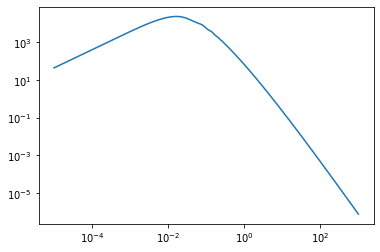

In [2]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=64
uni = universe(bs=n, nc=n,z_f=2,ipklin = ipklin )
uni.evolv()
flux_true = exp(-uni.final_tau_RSD)[0]

(64, 64, 64)
262144 65 262144
Total run time 3.8308777809143066


In [4]:
# write config file
def write_run():
    cf = open("run.cfg", "w")
    cf.write("lx = %f\n" % l)
    cf.write("ly = %f\n" % l)
    cf.write("lz = %f\n" % l)
    cf.write("num_pixels = %i\n" % num_pixels)
    cf.write("map_nx = %i\n" % map_n)
    cf.write("map_ny = %i\n" % map_n)
    cf.write("map_nz = %i\n" % map_n)
    cf.write("corr_var_s = %f\n"%var(flux_obs))
    cf.write("corr_l_perp = %f\n" % d_los)
    cf.write("corr_l_para = %f\n" % d_los)
    cf.write("pcg_tol = 1.0e-2\n")
    cf.write("pcg_max_iter = 1000\n")
    cf.close()

$k_1=6,k_2=6,k_3=0.7,k_3=0.5$

In [5]:
n_los = [600,900,1200,1500]
flux_opt_recon = []
flux_wiener_recon = []
for i in n_los:
    mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=i)
    mock_lya.select_skewers()
    opt_recon = reconstruct_opt(uni,mock_lya,anneal_steps=[2.5,1.5,1,0.7],k=[6,6,0.7,0.5],bound=False)
    opt_recon.initmodel()
    tau_opt_recon,flux_los_opt_recon = opt_recon.run_model()
    flux_opt = exp(-tau_opt_recon[0])
    flux_opt_recon.append(flux_opt)
    
    flux_obs = mock_lya.vals_observed
    flux_contrast = flux_obs/flux_obs.mean()-1
    p = np.vstack([mock_lya.skewers_fin.T[0], mock_lya.skewers_fin.T[1],mock_lya.skewers_fin.T[2], 1/(mock_lya.inverse_covar[1])**0.5/flux_obs.mean(), flux_contrast]).T
    p.tofile("pixel_data.bin")
    d_los = n/(i)**0.5
    l = n
    map_n = n
    num_pixels = len(mock_lya.skewers_fin.T[0])
    write_run()
    
    !/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/dachshund.exe run.cfg
    
    flux_contrast_wiener = np.fromfile('map.bin').reshape(n,n,n)
    flux_wiener = (flux_contrast_wiener+1)*flux_obs.mean()
    flux_wiener_recon.append(flux_wiener)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1675241.250000
  Number of iterations: 20
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1670263.125000
  Number of iterations: 40
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1661616.500000
  Number of iterations: 60
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1646424.375000
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 12.629604
Reading config file run

Text(0.5, 0.98, 'Optimized')

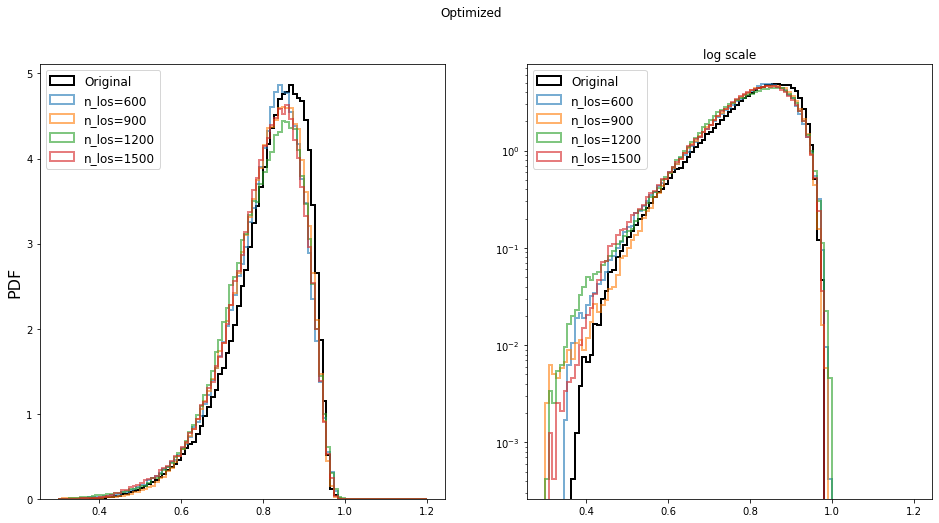

In [6]:
sigma = 2
fig = figure(figsize=(16,8))

bins=linspace(0.3,1.2,100)
ax1 = fig.add_subplot(121)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list,color='k')
for i,flux in enumerate(flux_opt_recon):
    ax1.hist(ndimage.gaussian_filter(flux,sigma).flatten(),label='n_los=%d'%n_los[i],alpha=0.6,**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)

ax1 = fig.add_subplot(122)
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list,color='k')
for i,flux in enumerate(flux_opt_recon):
    ax1.hist(ndimage.gaussian_filter(flux,sigma).flatten(),label='n_los=%d'%n_los[i],alpha=0.6,**h_list)
legend(loc=2,fontsize=12)
ax1.set_title('log scale')
yscale('log')
suptitle('Optimized')

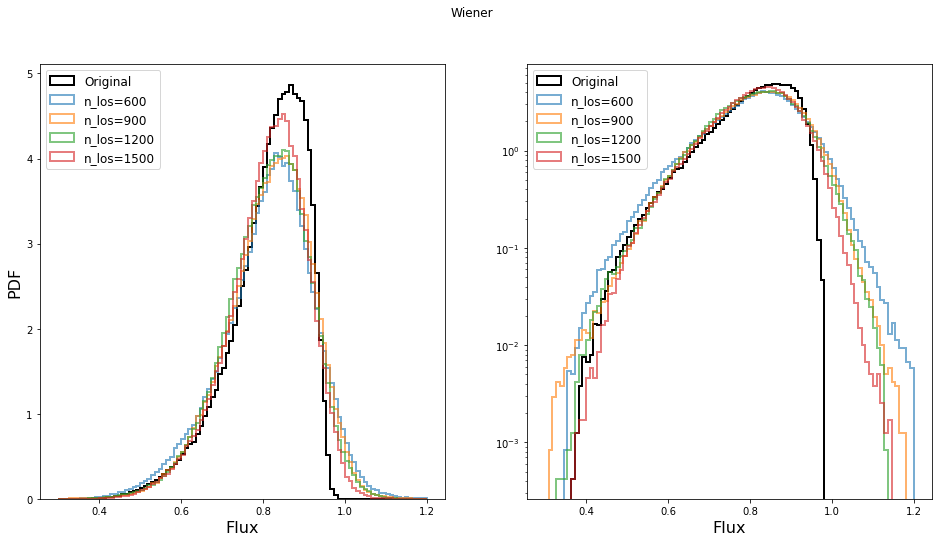

In [7]:
fig = figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list,color='k')
for i,flux in enumerate(flux_wiener_recon):
    ax1.hist(ndimage.gaussian_filter(flux,sigma).flatten(),label='n_los=%d'%n_los[i],alpha=0.6,**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)

ax1 = fig.add_subplot(122)
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list,color='k')
for i,flux in enumerate(flux_wiener_recon):
    ax1.hist(ndimage.gaussian_filter(flux,sigma).flatten(),label='n_los=%d'%n_los[i],alpha=0.6,**h_list)
legend(loc=2,fontsize=12)
ax1.set_xlabel('Flux',fontsize=16)
yscale('log')
suptitle('Wiener')
show()

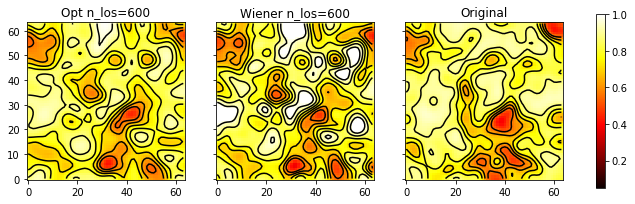

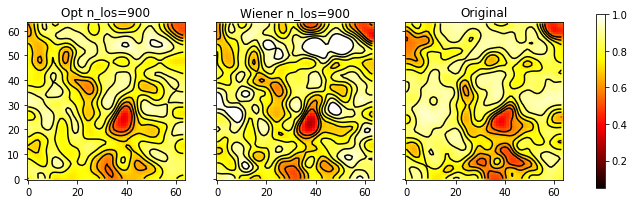

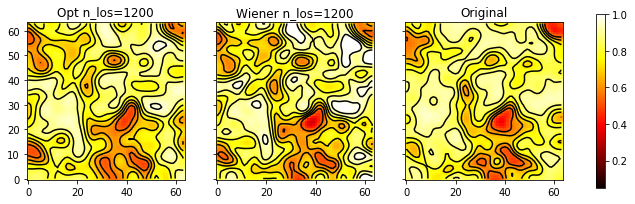

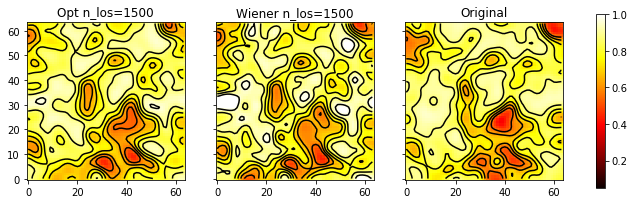

In [8]:
plot_list = {'vmin':0.05,'vmax':1,'cmap':"hot",'origin':'lower'}
con_list = {'levels':array([0.56, 0.64, 0.72, 0.8 , 0.88, 0.96]),'colors':'black'}
true_sm = ndimage.gaussian_filter(flux_true,2)
for i in range(len(flux_opt_recon)):
    for j in range(1):
        opt_sm =  ndimage.gaussian_filter(flux_opt_recon[i],2)
        wiener_sm =  ndimage.gaussian_filter(flux_wiener_recon[i],2)
        
        fig, ax = plt.subplots(1, 3, sharey='row',figsize=(12,4))

        im1 = ax[0].imshow(opt_sm[:,:,j],**plot_list)
        ax[0].contour(opt_sm[:,:,j],**con_list)
        ax[0].set_title('Opt n_los=%d'%n_los[i])
        
        im2 = ax[1].imshow(wiener_sm[:,:,j],**plot_list)
        ax[1].contour(wiener_sm[:,:,j],**con_list)
        ax[1].set_title('Wiener n_los=%d'%n_los[i])
        
        im3 = ax[2].imshow(true_sm[:,:,j],**plot_list)
        ax[2].contour(true_sm[:,:,j],**con_list)
        ax[2].set_title('Original')
        colorbar(im3,ax=ax,shrink=0.8)
#         suptitle(i,x=0.45)
    